In [2]:
from ase.io import read
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from pathlib import Path
from matplotlib import cm
from matplotlib.colors import Normalize

In [3]:
# # Fig 3b---- Scores vs generation

# scores = np.loadtxt('Data/scores_3b.dat')
# gen_no = np.loadtxt('Data/gen_3b.dat')

# n_pop=70

# print(scores.shape, gen_no.shape)

# fig3b, ax2 = plt.subplots(figsize=(3.5, 3), dpi=150, facecolor='white')
# cmap = cm.viridis_r

# for i in range(gen_no.shape[0]):
#     ranks = np.argsort(np.argsort(scores[i, :]))
#     norm = Normalize(vmin=ranks.min(), vmax=ranks.max())
#     colors_score = cmap(norm(ranks))

#     ax2.scatter([gen_no[i]] * n_pop, scores[i], alpha=0.7, edgecolor='orange', color='grey', s=38)

# ax2.set_xlabel('Generation')
# ax2.set_ylabel('Scores')
# ax2.tick_params(direction='in')
# #plt.savefig('Fig3b.pdf', bbox_inches='tight')

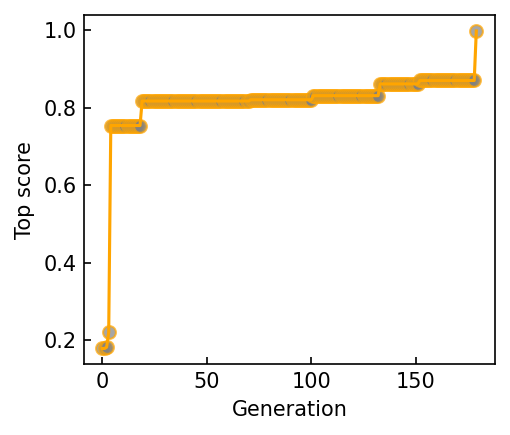

In [4]:
# Fig 3b---- Top Scores vs generation

import numpy as np
import matplotlib.pyplot as plt

# ── Load data ──────────────────────────────────────────────────────────────
scores  = np.loadtxt('Data/scores_3b.dat')   # shape: (n_gen, n_pop)
gen_no  = np.loadtxt('Data/gen_3b.dat').ravel()  # shape: (n_gen,)

top_scores = scores.max(axis=1)          # one value per generation

# ── Plot ───────────────────────────────────────────────────────────────────
fig2b, ax2 = plt.subplots(figsize=(3.5, 3), dpi=150, facecolor='white')

ax2.scatter(gen_no, top_scores, alpha=0.7, edgecolor='orange', color='grey', s=38)
ax2.plot(gen_no, top_scores, color='orange')

ax2.set_xlabel('Generation')
ax2.set_ylabel('Top score')
ax2.tick_params(direction='in')
fig2b.tight_layout()
plt.savefig('Fig3b_revised.pdf', bbox_inches='tight')
plt.show()


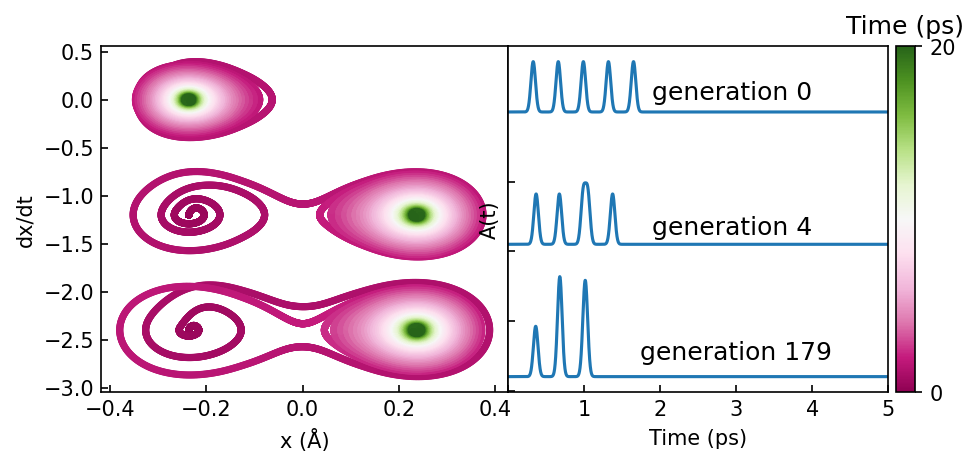

In [5]:
# Fig 3cd---- Phase space + Protocols

from mpl_toolkits.axes_grid1 import make_axes_locatable

sol_x_all = np.loadtxt('Data/sol_x_3c.dat')
sol_v_all = np.loadtxt('Data/sol_v_3c.dat')
At_all = np.loadtxt('Data/protocol_3d.dat')

freq_in_thz = 6.3507799295888985 
t_in_ps = 1 / freq_in_thz

tspan = [0, 20/t_in_ps]
tfine = np.linspace(*tspan, 20000)
norm2 = Normalize(vmin=np.min(tfine*t_in_ps), vmax=np.max(tfine*t_in_ps))

fig3cd, (ax3,ax4) = plt.subplots(1,2,figsize=(7, 3), dpi=150, facecolor='white')

for idx in range(len(sol_x_all)-1,-1,-1):
    sc=ax3.scatter(sol_x_all[idx], sol_v_all[idx]-1.2*idx, c = tfine*t_in_ps, cmap='PiYG', edgecolor='none', norm=norm2, s=12)
    ax4.plot(tfine*t_in_ps, At_all[idx]-0.95*idx, color='C0', label=f'gen {idx+1}')

ax3.set_xlabel('x (Å)')
ax3.set_ylabel('dx/dt')
ax3.tick_params(direction='in')

divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.set_position([0.8, 0.2, 0.03, 0.6])
cbar = fig3cd.colorbar(sc, cax=cax,orientation='vertical')
cbar.ax.set_title('Time (ps)')
cbar.set_ticks([norm2.vmin, norm2.vmax])
cbar.ax.set_yticklabels(['0', '20'])

ax4.set_xlabel('Time (ps)')
ax4.set_ylabel('A(t)', labelpad=0.5)
ax4.set_xlim(0,5)
ax4.tick_params(direction='in')

ax4.text(0.80, 0.90, "generation 0", transform=ax4.transAxes,fontsize=12, va='top', ha='right')
ax4.text(0.80, 0.51, "generation 4", transform=ax4.transAxes,fontsize=12, va='top', ha='right')
ax4.text(0.85, 0.15, "generation 179", transform=ax4.transAxes,fontsize=12, va='top', ha='right')
ax4.set_yticklabels([])
xticks_positions = ax4.get_xticks()
xticks_labels = ax4.get_xticklabels()
xticks_labels = [''] + [label.get_text() for label in xticks_labels[1:]]
ax4.set_xticks(xticks_positions)
ax4.set_xticklabels(xticks_labels)

plt.subplots_adjust(wspace=0)
#plt.savefig('Fig3cd.pdf', bbox_inches='tight')

In [10]:
from ase.io import read
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from pathlib import Path

# Bismuth parameters 
bi_mass = 208.9804
energy_in_ev = 0.004180159285619251 #1 THz = 0.0041 eV
freq_in_thz = 6.3507799295888985 
t_in_ps = 1 / freq_in_thz
x_saddle=0.23589477841686

energies = np.loadtxt("../../Input_files/toten.dat")
x = np.linspace(-0.5, 0.9, len(energies))
x=x-x_saddle # to shift saddle point to x=0
bi_yinterp = InterpolatedUnivariateSpline(x, np.array(energies) / energy_in_ev, k=5) # energies are converted to THz from eV
neg_bi_yinterp = InterpolatedUnivariateSpline(x, -np.array(energies) / energy_in_ev, k=5) # energies are converted to THz from eV
bi_xmin = minimize(bi_yinterp, [0.0], bounds=[(-0.1-x_saddle, 0.1-x_saddle)]).x
bi_xmin = bi_xmin[0]

bi_xmax = minimize(neg_bi_yinterp, [0.0], bounds=[(-0.1, 0.1)]).x
bi_xmax = bi_xmax[0]

bi_phomega = np.sqrt(bi_yinterp(bi_xmin, nu=2) / bi_mass)
bi_phfreq_in_thz = bi_phomega * freq_in_thz / (2 * np.pi)

from numpy.linalg import lstsq

# Base directory containing chi_* files
baseDir = "../../Input_files/chi_files"
all_pos2 = [4, 12, 16, 24, 28, 32, 38, 42, 48, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 68, 73, 80, 88, 96]

bi_eps_2eV = [
    row[1] + 1j * row[2]
    for i in all_pos2
    for row in np.loadtxt(f"{baseDir}/chi_{i}.dat", delimiter=" ")
    if 1.90 <= row[0] <= 2.05
]

bi_eps_2eV = np.array(bi_eps_2eV)

# Polynomial Regression Setup
x = x[all_pos2]
y = bi_eps_2eV.real

num = 9
X_poly = np.column_stack([x**i for i in range(0, num, 2)])  # Even powers

# Solve least squares problem
coefficients, _, _, _ = lstsq(X_poly, y, rcond=None)

# Polynomial and its derivative
poly_model = lambda x: sum(c * x**(2 * i) for i, c in enumerate(coefficients))
poly_derivative_func = lambda x: sum((2 * i) * c * x**(2 * i - 1) for i, c in enumerate(coefficients[1:], start=1))


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

a=2*np.pi*(1/19.5)/freq_in_thz
b=2*np.pi*(1/0.3)/freq_in_thz

print(a,b)

const_b1 = 1
const_w2 = 10

class TestFNN_ex2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, w1_array):
        super(TestFNN_ex2, self).__init__()
        # Simple feed-forward with one hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, output_size)
        #self.init_weights()
    
    #def init_weights(self):
        # Initialize weights and biases with Gaussian distribution (mean=0, std=1) 
        self.fc1.weight.data = torch.FloatTensor(w1_array).view(hidden_size, input_size)  # Ensure the correct shape
        nn.init.constant_(self.fc1.bias, const_b1)
        nn.init.constant_(self.fc2.weight, const_w2)
        nn.init.constant_(self.fc2.bias, 0)

    
    def forward(self, x):
        x = torch.sin(self.fc1(x))  # Using sinusoidal activation function
        x = self.fc2(x)
        return x
        
    def get_output(self, time):
        """Get neural network output for a given time input."""
        time_tensor = torch.tensor([[time]], dtype=torch.float32)
        with torch.no_grad():
            return self(time_tensor).item()

0.050736229992191274 3.297854949492433


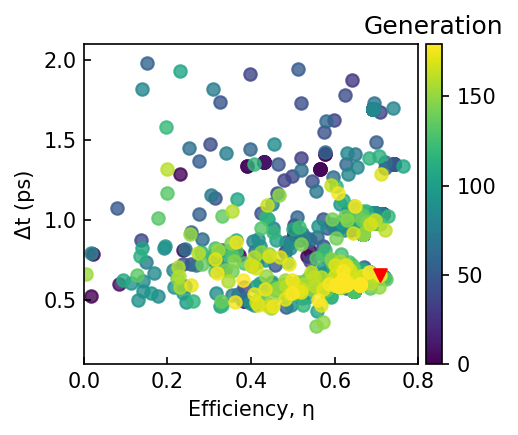

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.ticker import FormatStrFormatter
import pickle
from scipy.interpolate import interp1d
from scipy.integrate import simpson

# ── PARAMETERS ───────────────────────────────────────────────────────────────
no_pop = 70
top_k  = 10      # only plot the top‐10 per generation
alpha = 1.55

R_xmin = -82.78838661898314
max_Rx = -120.32419369046966
eff_denom = ((4/5)*alpha*(-max_Rx)) + ((alpha/5)*(-R_xmin))

# ── LOAD DATA ───────────────────────────────────────────────────────────
scores  = np.loadtxt('Data/scores_3b.dat')   # shape: (n_gen, no_pop)
gen_no  = np.loadtxt('Data/gen_3b.dat').astype(int)
no_gen  = scores.shape[0]

with open('Data/sol_x_3c.pkl', 'rb') as f: sol_x_all = pickle.load(f)
with open('Data/sol_v_3c.pkl', 'rb') as f: sol_v_all = pickle.load(f)
with open('Data/protocol_3d.pkl', 'rb') as f: At_all     = pickle.load(f)
with open('Data/pop_wt_pulses_fig3.pkl', 'rb') as f:
    _, fc1_wt = pickle.load(f)

# flatten everything so that index = gen_index * no_pop + pop_index
flat_x  = [sub for grp in sol_x_all     for sub in grp]
flat_v  = [sub for grp in sol_v_all     for sub in grp]
flat_At = [sub for grp in At_all        for sub in grp]
flat_wt = [sub for grp in fc1_wt        for sub in grp]

# ── PRECOMPUTE efficiency & Δt for every individual ─────────────────────────
eta = []
del_time = []

for idx in range(no_gen * no_pop):
    Rt_neg        = [-poly_derivative_func(x) for x in flat_x[idx]]
    norm_factor   = simpson(y=flat_At[idx]**2, x=tfine)
    sign_fac      = np.sign(flat_v[idx]) * np.sign(Rt_neg)
    driv_force    = sign_fac * Rt_neg * (((flat_At[idx]**2)*alpha)/norm_factor)
    int_driv_force= simpson(y=driv_force, x=tfine)
    eff           = int_driv_force/eff_denom
    t_i           = 2 * np.pi * (1/flat_wt[idx]) / freq_in_thz
    del_t         = (torch.max(t_i) - torch.min(t_i)).detach().numpy()
    
    eta.append(eff)
    del_time.append(del_t)

eta       = np.array(eta)
del_time  = np.array(del_time)

# ── PLOT group 0–179 (all gens) ─────────────────────────────────
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=150, facecolor='white')
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=no_gen-1)

for gen in range(no_gen):
    # select top-k indices in this generation
    best_idx = np.argsort(scores[gen])[-top_k:]
    base     = gen * no_pop

    gen_eta    = eta[base + best_idx]
    gen_del_t  = del_time[base + best_idx]
    mask       = gen_del_t < 2

    ax.scatter(
        gen_eta[mask],
        gen_del_t[mask],
        color=cmap(norm(gen)),
        s=36, alpha=0.8,
        label=None
    )

ax.scatter(eta[12561], del_time[12561], color='r', marker='v', s=36, label="Score=1")

ax.set_xlim(0, 0.8)
ax.set_ylim(0.1, 2.1)
ax.tick_params(direction='in')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
cbar.ax.set_title('Generation', pad=5)

ax.set_xlabel('Efficiency, η')
ax.set_ylabel('Δt (ps)')

plt.tight_layout()
#plt.savefig('Fig3f_0-179_top10.pdf', bbox_inches='tight')
plt.show()
